<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

last updated: 2017-08-22 

CPython 2.7.13
IPython 5.3.0

numpy 1.12.1
matplotlib 2.0.2
scipy 0.19.0
pandas 0.20.1
sklearn 0.18.1
mlxtend 0.7.0


# Cosmic-ray composition effective area analysis
### Table of contents
1. [Load simulation DataFrame and apply quality cuts](#Load-simulation-DataFrame-and-apply-quality-cuts)
2. [Define functions to be fit to effective area](#Define-functions-to-be-fit-to-effective-area)
3. [Calculate effective areas](#Calculate-effective-areas)
4. [Plot result](#Plot-result)

In [2]:
%matplotlib inline
from __future__ import division, print_function
from collections import defaultdict
import os
import numpy as np
from scipy import optimize
from scipy.stats import chisquare
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns

import comptools as comp

color_dict = comp.analysis.get_color_dict()

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load simulation DataFrame and apply quality cuts
[ [back to top](#top) ]

In [3]:
# config = 'IC79'
config = 'IC86.2012'
df_sim = comp.load_sim(config=config, test_size=0)

In [5]:
df_sim

,FractionContainment_Laputop_IceTop,FractionContainment_Laputop_InIce,FractionContainment_MCPrimary_IceTop,FractionContainment_MCPrimary_InIce,IceTopMaxSignal,IceTopMaxSignalInEdge,IceTopMaxSignalString,IceTopNeighbourMaxSignal,InIce_charge_1_60,MC_azimuth,...,lap_cos_zenith,log_s50,log_s80,log_s125,log_s180,log_s250,log_s500,log_dEdX,target,is_thinned
0,0.723129,0.975129,0.730482,0.983024,18.432690,0,10,14.470111,245.350001,2.912543,...,0.970416,1.089618,0.417746,-0.243566,-0.800776,-1.315759,-2.442802,0.527069,0,False
1,0.197626,0.803790,0.216988,0.827441,24.921978,0,79,19.548155,122.400000,2.912543,...,0.969793,1.133598,0.410655,-0.299151,-0.895983,-1.446662,-2.649023,0.528187,0,False
2,0.758493,0.741260,0.778203,0.776185,12.654794,0,15,4.653794,115.975000,2.912543,...,0.968690,0.941354,0.351498,-0.231935,-0.725515,-1.183174,-2.189262,0.376604,0,False
3,0.307622,0.593746,0.295832,0.578842,34.789658,0,54,8.977652,139.450000,2.912543,...,0.967562,0.894099,0.349628,-0.190710,-0.649078,-1.075016,-2.014172,0.300163,0,False
4,0.584972,0.929127,0.571597,0.949283,16.521660,0,17,15.387228,30.375000,2.912543,...,0.972129,0.996699,0.410424,-0.169610,-0.660412,-1.115568,-2.116376,0.444314,0,False
5,0.599457,0.825440,0.603860,0.834725,915.565613,0,64,266.637909,72.200000,2.912543,...,0.970588,0.965718,0.472972,-0.018253,-0.436491,-0.826276,-1.689150,0.669241,0,False
6,0.518328,0.687292,0.482674,0.619027,13.730797,0,24,6.145182,53.975000,2.912543,...,0.969633,0.875428,0.315497,-0.239522,-0.709884,-1.146627,-2.108583,0.291250,0,False
7,0.707230,0.219441,0.738094,0.231852,618.074707,0,52,397.986542,35.950000,2.912543,...,0.972208,1.340168,0.541520,-0.240171,-0.895737,-1.499329,-2.813338,0.148202,0,False
8,0.704877,0.789085,0.701785,0.782489,8.787918,0,15,4.478899,115.325000,2.912543,...,0.969743,0.988941,0.374217,-0.232830,-0.745702,-1.220742,-2.263505,0.494186,0,False
9,0.672916,0.596048,0.675481,0.649017,28.609421,0,29,12.178488,180.050000,5.673565,...,0.932002,1.058991,0.515847,-0.023232,-0.480570,-0.905580,-1.842779,0.733548,0,False


In [6]:
# df_sim, cut_dict_sim = comp.load_dataframe(datatype='sim', config=config, return_cut_dict=True)
# selection_mask = np.array([True] * len(df_sim))
# # standard_cut_keys = ['IceTopQualityCuts', 'lap_InIce_containment',
# # #                 'num_hits_1_60', 'max_qfrac_1_60',
# #                 'InIceQualityCuts', 'num_hits_1_60']

# standard_cut_keys = ['passed_IceTopQualityCuts', 'FractionContainment_Laputop_InIce',
#                      'passed_InIceQualityCuts', 'num_hits_1_60']
# # for cut in ['MilliNCascAbove2', 'MilliQtotRatio', 'MilliRloglBelow2', 'StochRecoSucceeded']:
# #     standard_cut_keys += ['InIceQualityCuts_{}'.format(cut)]
    
# for key in standard_cut_keys:
#     selection_mask *= cut_dict_sim[key]
#     print(key, np.sum(selection_mask))

# df_sim = df_sim[selection_mask]

#### Define energy binning for this analysis

In [7]:
log_energy_bins = np.arange(5.0, 9.51, 0.05)
# log_energy_bins = np.arange(5.0, 9.51, 0.1)
energy_bins = 10**log_energy_bins
energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2

energy_min_fit, energy_max_fit = 5.8, 7.0
midpoints_fitmask = (energy_midpoints >= 10**energy_min_fit) & (energy_midpoints <= 10**energy_max_fit)

In [8]:
log_energy_bins

array([ 5.  ,  5.05,  5.1 ,  5.15,  5.2 ,  5.25,  5.3 ,  5.35,  5.4 ,
        5.45,  5.5 ,  5.55,  5.6 ,  5.65,  5.7 ,  5.75,  5.8 ,  5.85,
        5.9 ,  5.95,  6.  ,  6.05,  6.1 ,  6.15,  6.2 ,  6.25,  6.3 ,
        6.35,  6.4 ,  6.45,  6.5 ,  6.55,  6.6 ,  6.65,  6.7 ,  6.75,
        6.8 ,  6.85,  6.9 ,  6.95,  7.  ,  7.05,  7.1 ,  7.15,  7.2 ,
        7.25,  7.3 ,  7.35,  7.4 ,  7.45,  7.5 ,  7.55,  7.6 ,  7.65,
        7.7 ,  7.75,  7.8 ,  7.85,  7.9 ,  7.95,  8.  ,  8.05,  8.1 ,
        8.15,  8.2 ,  8.25,  8.3 ,  8.35,  8.4 ,  8.45,  8.5 ,  8.55,
        8.6 ,  8.65,  8.7 ,  8.75,  8.8 ,  8.85,  8.9 ,  8.95,  9.  ,
        9.05,  9.1 ,  9.15,  9.2 ,  9.25,  9.3 ,  9.35,  9.4 ,  9.45,  9.5 ])

In [9]:
np.log10(energy_midpoints[midpoints_fitmask])

array([ 5.82571916,  5.87571916,  5.92571916,  5.97571916,  6.02571916,
        6.07571916,  6.12571916,  6.17571916,  6.22571916,  6.27571916,
        6.32571916,  6.37571916,  6.42571916,  6.47571916,  6.52571916,
        6.57571916,  6.62571916,  6.67571916,  6.72571916,  6.77571916,
        6.82571916,  6.87571916,  6.92571916,  6.97571916])

### Define functions to be fit to effective area

In [10]:
def constant(energy, c):
    return c

def linefit(energy, m, b):
    return m*np.log10(energy) + b

def sigmoid_flat(energy, p0, p1, p2):
    return p0 / (1 + np.exp(-p1*np.log10(energy) + p2))

def sigmoid_slant(energy, p0, p1, p2, p3):
    return (p0 + p3*np.log10(energy)) / (1 + np.exp(-p1*np.log10(energy) + p2))

In [11]:
def red_chisquared(obs, fit, sigma, n_params):
    zero_mask = sigma != 0
    return np.nansum(((obs[zero_mask] - fit[zero_mask])/sigma[zero_mask]) ** 2) / (len(obs[zero_mask]) - n_params)
#     return np.sum(((obs - fit)/sigma) ** 2) / (len(obs) - 1 - n_params)

In [12]:
np.sum(midpoints_fitmask)-3

21

### Calculate effective areas

In [13]:
eff_area, eff_area_error, _ = comp.calculate_effective_area_vs_energy(df_sim, energy_bins)
eff_area_light, eff_area_error_light, _ = comp.calculate_effective_area_vs_energy(df_sim[df_sim.MC_comp_class == 'light'], energy_bins)
eff_area_heavy, eff_area_error_heavy, _ = comp.calculate_effective_area_vs_energy(df_sim[df_sim.MC_comp_class == 'heavy'], energy_bins)

Calculating effective area...
Simulation set 12360: 19781 files
Simulation set 12362: 19808 files
Simulation set 12630: 19787 files
Simulation set 12631: 19834 files
Calculating effective area...
Simulation set 12360: 19781 files
Simulation set 12630: 19787 files
Calculating effective area...
Simulation set 12362: 19808 files
Simulation set 12631: 19834 files


In [71]:
eff_area, eff_area_error, _ = comp.analysis.get_effective_area(df_sim,
                                                                energy_bins, energy='MC')
eff_area_light, eff_area_error_light, _ = comp.analysis.get_effective_area(
                                                                df_sim[df_sim.MC_comp_class == 'light'],
                                                                energy_bins, energy='MC')
eff_area_heavy, eff_area_error_heavy, _ = comp.analysis.get_effective_area(
                                                                df_sim[df_sim.MC_comp_class == 'heavy'],
                                                                energy_bins, energy='MC')

Calculating effective area...
simlist = [12360 12362 12630 12631]
Simulation set 12360: 19781 files
type(sim) = <type 'numpy.int64'>
sim = 12360
Simulation set 12362: 19808 files
type(sim) = <type 'numpy.int64'>
sim = 12362
Simulation set 12630: 19787 files
type(sim) = <type 'numpy.int64'>
sim = 12630
Simulation set 12631: 19834 files
type(sim) = <type 'numpy.int64'>
sim = 12631
num_ptypes = 4
Calculating effective area...
simlist = [12360 12630]
Simulation set 12360: 19781 files
type(sim) = <type 'numpy.int64'>
sim = 12360
Simulation set 12630: 19787 files
type(sim) = <type 'numpy.int64'>
sim = 12630
num_ptypes = 2
Calculating effective area...
simlist = [12362 12631]
Simulation set 12362: 19808 files
type(sim) = <type 'numpy.int64'>
sim = 12362
Simulation set 12631: 19834 files
type(sim) = <type 'numpy.int64'>
sim = 12631
num_ptypes = 2


In [14]:
eff_area_light

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         5.24026972e+01,   5.34145001e+01,   3.26247872e+02,
         1.31356318e+03,   8.64194357e+02,   2.88359479e+03,
         4.32422452e+03,   8.96141417e+03,   1.21499869e+04,
         2.19251818e+04,   3.35217211e+04,   4.60892729e+04,
         6.00292849e+04,   8.13773734e+04,   7.84626788e+04,
         9.71846210e+04,   1.07211232e+05,   1.23782486e+05,
         1.32868673e+05,   1.21280851e+05,   1.31204956e+05,
         1.39347403e+05,   1.21366758e+05,   1.30505274e+05,
         1.33588715e+05,   1.41885917e+05,   1.47158581e+05,
         1.55710566e+05,   1.44095655e+05,   1.53291849e+05,
         1.39841590e+05,   1.49307117e+05,   1.33264659e+05,
         1.43413024e+05,   1.33854688e+05,   1.36742008e+05,
         1.41580651e+05,   1.54560314e+05,   1.34595585e+05,
         1.30231468e+05,   1.44190774e+05,   1.51709532e+05,
         1.21735053e+05,

#### Fit functions to effective area data

In [15]:
p0 = [1.5e5, 8.0, 50.0]
popt_light, pcov_light = optimize.curve_fit(sigmoid_flat, energy_midpoints[midpoints_fitmask],
                                            eff_area_light[midpoints_fitmask], p0=p0,
                                            sigma=eff_area_error_light[midpoints_fitmask])
popt_heavy, pcov_heavy = optimize.curve_fit(sigmoid_flat, energy_midpoints[midpoints_fitmask],
                                            eff_area_heavy[midpoints_fitmask], p0=p0,
                                            sigma=eff_area_error_heavy[midpoints_fitmask])

In [16]:
print(popt_light)
print(popt_heavy)

[  1.41746363e+05   7.77283311e+00   4.63861302e+01]
[  1.36838018e+05   9.38458915e+00   5.66947059e+01]


In [17]:
perr_light = np.sqrt(np.diag(pcov_light))
print(perr_light)
perr_heavy = np.sqrt(np.diag(pcov_heavy))
print(perr_heavy)

[  2.53034467e+03   6.21806613e-01   3.67077785e+00]
[  3.01846146e+03   7.11873552e-01   4.22664184e+00]


In [18]:
avg = (popt_light[0] + popt_heavy[0]) / 2
print('avg eff area = {}'.format(avg))

avg eff area = 139292.190378


In [19]:
eff_area_light

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         5.24026972e+01,   5.34145001e+01,   3.26247872e+02,
         1.31356318e+03,   8.64194357e+02,   2.88359479e+03,
         4.32422452e+03,   8.96141417e+03,   1.21499869e+04,
         2.19251818e+04,   3.35217211e+04,   4.60892729e+04,
         6.00292849e+04,   8.13773734e+04,   7.84626788e+04,
         9.71846210e+04,   1.07211232e+05,   1.23782486e+05,
         1.32868673e+05,   1.21280851e+05,   1.31204956e+05,
         1.39347403e+05,   1.21366758e+05,   1.30505274e+05,
         1.33588715e+05,   1.41885917e+05,   1.47158581e+05,
         1.55710566e+05,   1.44095655e+05,   1.53291849e+05,
         1.39841590e+05,   1.49307117e+05,   1.33264659e+05,
         1.43413024e+05,   1.33854688e+05,   1.36742008e+05,
         1.41580651e+05,   1.54560314e+05,   1.34595585e+05,
         1.30231468e+05,   1.44190774e+05,   1.51709532e+05,
         1.21735053e+05,

In [20]:
light_chi2 = red_chisquared(eff_area_light, sigmoid_flat(energy_midpoints, *popt_light),
               eff_area_error_light, len(popt_light))
print(light_chi2)
heavy_chi2 = red_chisquared(eff_area_heavy,
               sigmoid_flat(energy_midpoints, *popt_heavy),
               eff_area_error_heavy, len(popt_heavy))
print(heavy_chi2)

38.0787059901
9.92114463142


### Plot result

/home/jbourbeau/.virtualenvs/composition/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


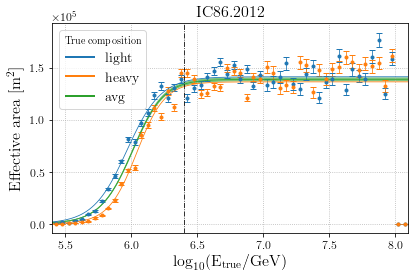

In [21]:
fig, ax = plt.subplots()
# plot effective area data points with poisson errors
ax.errorbar(np.log10(energy_midpoints), eff_area_light, yerr=eff_area_error_light,
            ls='None', marker='.')
ax.errorbar(np.log10(energy_midpoints), eff_area_heavy, yerr=eff_area_error_heavy,
            ls='None', marker='.')

# plot corresponding sigmoid fits to effective area
x = 10**np.arange(5.0, 9.5, 0.01)
ax.plot(np.log10(x), sigmoid_flat(x, *popt_light),
        color=color_dict['light'], label='light', marker='None', ls='-')
ax.plot(np.log10(x), sigmoid_flat(x, *popt_heavy),
        color=color_dict['heavy'], label='heavy', marker='None')


avg_eff_area = (sigmoid_flat(x, *popt_light) + sigmoid_flat(x, *popt_heavy)) / 2
ax.plot(np.log10(x), avg_eff_area,
        color=color_dict['total'], label='avg', marker='None')
ax.fill_between(np.log10(x),
        avg_eff_area-0.01*avg_eff_area,
        avg_eff_area+0.01*avg_eff_area,
        color=color_dict['total'], alpha=0.5)

ax.axvline(6.4, marker='None', ls='-.', color='k')

ax.set_ylabel('Effective area [m$^2$]')
ax.set_xlabel('$\mathrm{\log_{10}(E_{true}/GeV)}$')
# ax.set_title('$\mathrm{A_{eff} = 143177 \pm 1431.77 \ m^2}$')
ax.grid()
# ax.set_ylim([0, 180000])
ax.set_xlim([5.4, 8.1])
ax.set_title(config)

#set label style        
ax.ticklabel_format(style='sci',axis='y')
ax.yaxis.major.formatter.set_powerlimits((0,0))

leg = plt.legend(title='True composition')
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)

# eff_area_outfile = os.path.join(comp.paths.figures_dir, 'effective-area-{}.png'.format(config))
# comp.check_output_dir(eff_area_outfile)
# plt.savefig(eff_area_outfile)
plt.show()

Effective area as quality cuts are sequentially applied

In [19]:
df_sim, cut_dict_sim = comp.load_dataframe(datatype='sim', config='IC79', return_cut_dict=True)
standard_cut_keys = ['num_hits_1_60', 'IceTopQualityCuts', 'lap_InIce_containment',
#                 'num_hits_1_60', 'max_qfrac_1_60',
                'InIceQualityCuts']
# for cut in ['MilliNCascAbove2', 'MilliQtotRatio', 'MilliRloglBelow2', 'StochRecoSucceeded']:
#     standard_cut_keys += ['InIceQualityCuts_{}'.format(cut)]

eff_area_dict = {}
eff_area_err_dict = {}
selection_mask = np.array([True] * len(df_sim))
for key in standard_cut_keys:
    selection_mask *= cut_dict_sim[key]
    print(key, np.sum(selection_mask))
    eff_area, eff_area_error, _ = comp.analysis.get_effective_area(df_sim[selection_mask],
                                                                energy_bins, energy='MC')
#     eff_area, eff_area_error = comp.analysis.effective_area.effective_area(df_sim[selection_mask],
#                                                                            np.arange(5.0, 9.51, 0.1))
    eff_area_dict[key] = eff_area
    eff_area_err_dict[key] = eff_area_error

num_hits_1_60 397466
Calculating effective area...
Simulation set 7006: 30000 files
Simulation set 7007: 30000 files
Simulation set 7241: 10000 files
Simulation set 7242: 10000 files
Simulation set 7262: 19999 files
Simulation set 7263: 19998 files
Simulation set 7579: 12000 files
Simulation set 7784: 12000 files
Simulation set 7791: 12000 files
Simulation set 7851: 12000 files
IceTopQualityCuts 397466
Calculating effective area...
Simulation set 7006: 30000 files
Simulation set 7007: 30000 files
Simulation set 7241: 10000 files
Simulation set 7242: 10000 files
Simulation set 7262: 19999 files
Simulation set 7263: 19998 files
Simulation set 7579: 12000 files
Simulation set 7784: 12000 files
Simulation set 7791: 12000 files
Simulation set 7851: 12000 files
lap_InIce_containment 308874
Calculating effective area...
Simulation set 7006: 30000 files
Simulation set 7007: 30000 files
Simulation set 7241: 10000 files
Simulation set 7242: 10000 files
Simulation set 7262: 19999 files
Simulation

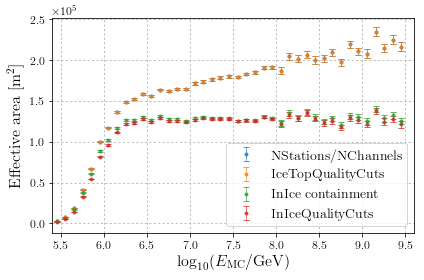

In [20]:
fig, ax = plt.subplots()
cut_labels = {'num_hits_1_60': 'NStations/NChannels', 'IceTopQualityCuts': 'IceTopQualityCuts',
             'lap_InIce_containment': 'InIce containment', 'InIceQualityCuts': 'InIceQualityCuts'}
for key in standard_cut_keys:
# plot effective area data points with poisson errors
    ax.errorbar(np.log10(energy_midpoints), eff_area_dict[key], yerr=eff_area_err_dict[key],
                ls='None', marker='.', label=cut_labels[key], alpha=0.75)

ax.set_ylabel('Effective area [m$^2$]')
ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
ax.grid()
# ax.set_ylim([0, 180000])
ax.set_xlim([5.4, 9.6])

#set label style        
ax.ticklabel_format(style='sci',axis='y')
ax.yaxis.major.formatter.set_powerlimits((0,0))

leg = plt.legend()

plt.savefig('/home/jbourbeau/public_html/figures/effective-area-cuts.png')
plt.show()